In [1]:
import pyphen
import string
import re
import collections

import numpy as np

from keras.models import Sequential
from keras.layers import Dense, Flatten
import keras

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [ ]:
%load_ext pep8_magic

In [2]:
hun_chars = 'aábcdeéfghiíjklmnoóöőpqrstuúüűvwxyz' + '^$'  # ^,$


def hyph_tags(word, hypher=pyphen.Pyphen(lang='hu_HU'), aslist=False):
    """Hyphenating classification of the characters in the word.
    {B(egin),M(iddle),E(nd),S(ingle)}"""
    if (len(word) == 0):
        raise IndexError("0 length word")
    ret = list('M' * len(word))
    ret[0] = 'B'
    ret[-1] = 'E'
    for i in hypher.positions(word):
        ret[i] = 'B'
        if(ret[i-1] == 'B'):
            ret[i-1] = 'S'
        else:
            ret[i-1] = 'E'
    if (aslist):
        return ret
    return "".join(ret)


def hyph_tags_4to2(word, aslist=False):
    """{B,M,E,S} to {B, M}"""
    ret = list(word)
    for i in range(len(ret)):
        if ret[i] == 'S':
            ret[i] = 'B'
        if ret[i] != 'B':
            ret[i] = 'M'
    if(aslist):
        return ret
    return "".join(ret)


def same_char_num(word, hypher=pyphen.Pyphen(lang='hu_HU')):
    """Return true if the hyphenated word has as many chars as the original"""
    return len(hypher.inserted(word)) == len(word)+len(hypher.positions(word))


def cleaning(data):
    """Text cleaning:
        lower the letters
        punctuation, digits ellimination"""
    formated_data = data.lower()
    formated_data = re.sub('['+string.punctuation+']', '', formated_data)
    formated_data = re.sub('['+string.digits+']', '', formated_data)
    return formated_data


# onehot: {'B','M','E','S'}
def one_hot_encode(char, dictionary='BMES'):
    ret = [0]*len(dictionary)
    if char in dictionary:
        ret[dictionary.find(char)] = 1
        return ret
    raise ValueError('Value out of dictionary range: '+char)


def unison_shuffled_copies(a, b):
    """Randomize 2 same length array in the same permutation"""
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]


def one_hot_decode(arr, dictionary='BMES'):
    assert len(arr) == len(dictionary)
    i = np.nonzero(arr)[0][0]
    return dictionary[i]


def generate_network_data(data, ret_input=[], ret_output=[],
                          length=2, length_after=0,
                          start_char='^', end_char='$',
                          chars=hun_chars, tag_chars='BMES'):
    """from [word,hyph_class(word) to length-long input-output data"""
    word = data[0]
    word_plus = start_char*(length-length_after-1)+word+end_char*length_after
    hyph_word = data[1]
    for i in range(0, len(word)):
        input_next_iter = []
        for c in word_plus[i:i+length]:
            input_next_iter.append(one_hot_encode(c, chars))
        output_next_iter = one_hot_encode(hyph_word[i], tag_chars)
        ret_input.append(input_next_iter)
        ret_output.append(output_next_iter)
    return

def hyph_tupples(data, hypher=pyphen.Pyphen(lang='hu_HU'),
                tag_chars='BM'):
    """[words] -> [words, hyph_words]"""
    word_list = []
    c_all = 0
    c_same_char_num = 0
    for next_word in data:
        c_all += 1
        if(len(next_word) != 0 and same_char_num(next_word, hypher)):
            c_same_char_num += 1
            if(len(tag_chars) == 2):
                word_list.append([next_word,
                                  hyph_tags_4to2(hyph_tags(next_word))])
            else:
                word_list.append([next_word, hyph_tags(next_word)])
    return word_list, c_all, c_same_char_num

def tupple_to_train(word_list, window_length, length_after,
                 tag_chars='BM'):
    """[words, hyph_words] -> in[0,1,0...], out[0,1,0...]"""
    data_in = []
    data_out = []
    wrong_word = 0
    for word in word_list:
        try:
            generate_network_data(word, data_in, data_out,
                                  window_length, tag_chars=tag_chars,
                                  length_after=length_after)
        except ValueError:
            wrong_word += 1
    return data_in, data_out, wrong_word

def bigram_counter_from_file(filename):
    """creates bigram counter from file"""
    with open(filename) as f:
        word_list = []
        for words in f:
            words = words.strip()
            words = words.split()
            for w in words:
                w = cleaning(w)
                if len(w)>0:
                    word_list.append(w)

    bigram_counter = collections.Counter()
    for word in word_list:
        for i in range(2,len(word)):
            bigram_counter[word[i-2:i]] += 1
    return bigram_counter

def bigrams_in_word(word, bigram_counter, mc=100):
    bigrams = np.array(bigram_counter.most_common(mc))[:,0]
    w_bc = len(word)-1
    if w_bc<1:
        return 1.0
    w_bf = 0
    for i in range(2,len(word)):
        if word[i-2:i] in bigrams:
            w_bf +=1
    return w_bf/w_bc

def bigram_selector(word, bigram_counters,threshold=0.2, mc=100):
    """Choose the language of the word"""
    lang_likes = np.zeros(len(bigram_counters)+1)
    for i in range(0,len(bigram_counters)):
        lang_likes[i] = bigrams_in_word(word, bigram_counters[i], mc)
    lang_likes_max = np.argmax(lang_likes)
    
    for i in range(0,len(bigram_counters)):
        if i!=lang_likes_max:
            if lang_likes[lang_likes_max]-lang_likes[i]<=threshold:
                return len(bigram_counters)
    return lang_likes_max

# Data import

In [3]:
def data_reader(file, tail_cut=100000,
                lang_selector = False, lang_thr=0.6,
                lang_file_en='../wikipedia/angol/ossz_angol',
                lang_file_hu='../wikipedia/magyar/ossz_magyar'):
    """Read data from file"""

    if lang_selector:
        bigram_counter_en = bigram_counter_from_file(lang_file_en)
        bigram_counter_hu = bigram_counter_from_file(lang_file_hu)
        out_en_words = 0
    
    tail_cut_ptest_words = tail_cut + 500

    counter_hu_data = collections.Counter()
    with open(file, 'r',
              errors='ignore', encoding='latin2') as f:
        i = 0
        for line in f:
            i = i+1
            words = line.split()
            if len(words) > 1:
                if(words[1].isdigit()):
                    cword = cleaning(words[0])
                    if lang_selector:
                        lang = bigram_selector(cword,
                                            [bigram_counter_hu,
                                             bigram_counter_en],
                                            lang_thr)
                        if (lang!=1):
                            counter_hu_data[cword] += int(words[1])
                        else:
                            out_en_words +=1
                    else:
                        counter_hu_data[cword] += int(words[1])
            if i > tail_cut_ptest_words:
                break
    if lang_selector:
        print("Throwed english words: ", out_en_words)
    return counter_hu_data

In [4]:
def train_data_generator(data_counter, window_length, length_after,
                         tag_chars='BM', tail_cut=100000,
                         valid_rate=0.2, test_rate=0.1):
    """Generate training data from counter data
    unique words -> characters -> randomize -> cut"""

    data_list = np.array(data_counter.most_common(tail_cut))[:,0]
    word_list, c_all, c_same_char_num = hyph_tupples(data_list,
                                                    tag_chars=tag_chars)
    print('Data read successfully')
    print('non-standard hyphenation:')
    print(c_same_char_num, c_all, c_same_char_num/c_all)

    # Generate network data
    data_in = []
    data_out = []
    wrong_word = 0
    data_in, data_out, wrong_word = tupple_to_train(word_list,
                                                    window_length,
                                                    length_after,
                                                    tag_chars=tag_chars)
    print('Data len: ', len(data_in))
    print('Words with unrecognized caracter: ', wrong_word)

    data_len = len(data_in)

    data_in = np.array(data_in, dtype='float32')
    data_out = np.array(data_out, dtype='float32')
    data_in, data_out = unison_shuffled_copies(data_in, data_out)
    tests_input = data_in[0:int(data_len*test_rate)]
    tests_target = data_out[0:int(data_len*test_rate)]
    valid_input = data_in[int(data_len*test_rate):
                          int(data_len*(test_rate+valid_rate))]
    valid_target = data_out[int(data_len*test_rate):
                            int(data_len*(test_rate+valid_rate))]
    train_input = data_in[int(data_len*(test_rate+valid_rate)):]
    train_target = data_out[int(data_len*(test_rate+valid_rate)):]

    print('Training data size:', np.shape(train_input), np.shape(train_target))
    print('Validation data size:', np.shape(valid_input),
          np.shape(valid_target))
    print('Test data size:', np.shape(tests_input), np.shape(tests_target))

    train_input_flatten = np.reshape(
        train_input, (len(train_input), (window_length)*len(hun_chars)))
    valid_input_flatten = np.reshape(
        valid_input, (len(valid_input), (window_length)*len(hun_chars)))
    tests_input_flatten = np.reshape(
        tests_input, (len(tests_input), (window_length)*len(hun_chars)))
    print('Network data generated successfully')

    return [train_input_flatten, train_target,
            valid_input_flatten, valid_target,
            tests_input_flatten, tests_target]


def train_data_generator_uwords(data_counter, window_length, length_after,
                                tag_chars='BM', tail_cut=100000,
                                valid_rate=0.2, test_rate=0.1):
    """Generate training data from counter data
        unique words -> randomize -> cut -> characters"""
    data_list = np.array(data_counter.most_common(tail_cut))[:,0]
    np.random.shuffle(data_list)
    data_len = len(data_list)
    tests_data = data_list[0:int(data_len*test_rate)]
    valid_data = data_list[int(data_len*test_rate):
                           int(data_len*(test_rate+valid_rate))]
    train_data = data_list[int(data_len*(test_rate+valid_rate)):]
    
    c_all = 0
    c_same_char_num = 0
    tests_list, c_all_p, c_same_char_num_p = hyph_tupples(tests_data,
                                                          tag_chars=tag_chars)
    c_all += c_all_p
    c_same_char_num += c_same_char_num_p
    valid_list, c_all_p, c_same_char_num_p = hyph_tupples(valid_data,
                                                          tag_chars=tag_chars)
    c_all += c_all_p
    c_same_char_num += c_same_char_num_p
    train_list, c_all_p, c_same_char_num_p = hyph_tupples(train_data,
                                                          tag_chars=tag_chars)
    c_all += c_all_p
    c_same_char_num += c_same_char_num_p
    
    print('Data read successfully')
    print('non-standard hyphenation:')
    print(c_same_char_num, c_all, c_same_char_num/c_all)
    
    wrong_word = 0
    tests_input, tests_target, wrong_w_p = tupple_to_train(tests_list,
                                                           window_length,
                                                           length_after,
                                                           tag_chars=tag_chars)
    wrong_word += wrong_w_p
    valid_input, valid_target, wrong_w_p = tupple_to_train(valid_list,
                                                           window_length,
                                                           length_after,
                                                           tag_chars=tag_chars)
    wrong_word += wrong_w_p
    train_input, train_target, wrong_w_p = tupple_to_train(train_list,
                                                           window_length,
                                                           length_after,
                                                           tag_chars=tag_chars)
    wrong_word += wrong_w_p
    print('Words with unrecognized caracter: ', wrong_word)

    print('Training data size:', np.shape(train_input), np.shape(train_target))
    print('Validation data size:', np.shape(valid_input),
          np.shape(valid_target))
    print('Test data size:', np.shape(tests_input), np.shape(tests_target))

    train_input_flatten = np.reshape(
        train_input, (len(train_input), (window_length)*len(hun_chars)))
    valid_input_flatten = np.reshape(
        valid_input, (len(valid_input), (window_length)*len(hun_chars)))
    tests_input_flatten = np.reshape(
        tests_input, (len(tests_input), (window_length)*len(hun_chars)))
    print('Network data generated successfully')

    return [train_input_flatten, train_target,
            valid_input_flatten, valid_target,
            tests_input_flatten, tests_target]
    

def train_data_generator_uchars(data_counter, window_length, length_after,
                                tag_chars='BM', tail_cut=100000,
                                valid_rate=0.2, test_rate=0.1):
    """Generate training data from counter data
        unique words -> characters -> unique -> randomize -> cut"""
    data_list = np.array(data_counter.most_common(tail_cut))[:,0]
    word_list, c_all, c_same_char_num = hyph_tupples(data_list,
                                                    tag_chars=tag_chars)
    print('Data read successfully')
    print('non-standard hyphenation:')
    print(c_same_char_num, c_all, c_same_char_num/c_all)

    # Generate network data
    data_in = []
    data_out = []
    wrong_word = 0
    data_in, data_out, wrong_word = tupple_to_train(word_list,
                                                    window_length,
                                                    length_after,
                                                    tag_chars=tag_chars)
    print('Data len: ', len(data_in))
    print('Words with unrecognized caracter: ', wrong_word)

    #Unique
    data_len = len(data_in)

    data_in = np.array(data_in, dtype='float32')
    data_out = np.array(data_out, dtype='float32')
    
    shape_in = np.shape(data_in)
    shape_out = np.shape(data_out)
    
    data_in_flatten = np.reshape(
        data_in, (shape_in[0], shape_in[1]*shape_in[2]))
    shape_in_flatten = np.shape(data_in_flatten)
    
    data_iosum = np.concatenate((data_in_flatten, data_out), axis=1)
    data_iosum_unique = np.vstack({tuple(row) for row in data_iosum})
    
    data_in = data_iosum_unique[:,:-shape_out[1]]
    data_out = data_iosum_unique[:,-shape_out[1]:]
    print('Data unique len: ', np.shape(data_iosum_unique)[0])
    
    data_len = len(data_in)
    data_in, data_out = unison_shuffled_copies(data_in, data_out)
    tests_input = data_in[0:int(data_len*test_rate)]
    tests_target = data_out[0:int(data_len*test_rate)]
    valid_input = data_in[int(data_len*test_rate):
                          int(data_len*(test_rate+valid_rate))]
    valid_target = data_out[int(data_len*test_rate):
                            int(data_len*(test_rate+valid_rate))]
    train_input = data_in[int(data_len*(test_rate+valid_rate)):]
    train_target = data_out[int(data_len*(test_rate+valid_rate)):]

    print('Training data size:', np.shape(train_input), np.shape(train_target))
    print('Validation data size:', np.shape(valid_input),
          np.shape(valid_target))
    print('Test data size:', np.shape(tests_input), np.shape(tests_target))

    train_input_flatten = np.reshape(
        train_input, (len(train_input), (window_length)*len(hun_chars)))
    valid_input_flatten = np.reshape(
        valid_input, (len(valid_input), (window_length)*len(hun_chars)))
    tests_input_flatten = np.reshape(
        tests_input, (len(tests_input), (window_length)*len(hun_chars)))
    print('Network data generated successfully')

    return [train_input_flatten, train_target,
            valid_input_flatten, valid_target,
            tests_input_flatten, tests_target]
    

# DNN Model

In [5]:
def model_creator(window_length, output_length, num_layers=1,
                  num_hidden=10, chars=hun_chars):
    """Creates Keras model with the given input, output dimensions
    and layer number, hidden layer length"""
    model = Sequential()
    model.add(Dense(input_dim=((window_length)*len(chars)),
                    units=num_hidden, name='input_layer',
                    activation='sigmoid'))
    for i in range(1, num_layers):
        model.add(Dense(units=num_hidden, activation='sigmoid'))

    # model.add(Flatten())
    model.add(Dense(output_length, name='output_layer', activation='softmax'))

    if(output_length == 2):
        model.compile(loss='binary_crossentropy', optimizer='adam')
    else:
        model.compile(loss='categorical_crossentropy', optimizer='adam')
    return model

# Main

In [6]:
tail_cut = 100000
window_length = 7
length_after = 3
tag_chars = 'BM'
num_layers = 5
num_hidden = 110

# Data read and network data generate
counter_hu_data = data_reader('web2.2-freq-sorted.txt',tail_cut, lang_selector=False)
[train_input_flatten, train_target,
 valid_input_flatten, valid_target,
 tests_input_flatten,
 tests_target] = train_data_generator_uwords(counter_hu_data,
                                             window_length,
                                             length_after,
                                             tag_chars,
                                             tail_cut)

# Creating the keras model
model = model_creator(window_length, len(tag_chars),
                      num_layers, num_hidden)
print('Model created. Start training...')

earlyStopping = keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=20, verbose=0, mode='auto')

Data read successfully
non-standard hyphenation:
82563 83678 0.9866751117378523
Words with unrecognized caracter:  646
Training data size: (489063, 7, 37) (489063, 2)
Validation data size: (139366, 7, 37) (139366, 2)
Test data size: (69880, 7, 37) (69880, 2)
Network data generated successfully
Model created. Start training...


In [7]:
history = model.fit(train_input_flatten, train_target,
                    epochs=1000, batch_size=1024,
                    validation_data=(valid_input_flatten, valid_target),
                    verbose=0, callbacks=[earlyStopping])

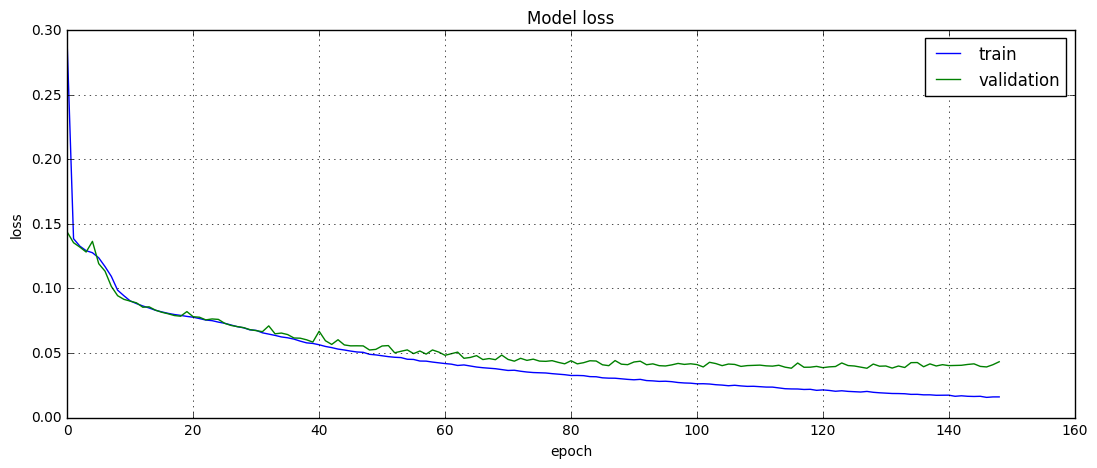

In [8]:
# summarize history for loss
plt.figure(figsize=(13, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
#plt.ylim((0.04, 0.06))
plt.grid()
plt.show()

In [9]:
model.save('models/mBM7uwordsNo1.h5')

# Evaluation

In [49]:
test_results = model.predict(tests_input_flatten)
test_tp = 0
test_fp = 0
test_tn = 0
test_fn = 0
test_str = ""
if(np.shape(test_results)[1] == 2):
    for i in range(len(test_results)):
        # positive
        if np.argmax(test_results[i]) == 1:
            if np.argmax(tests_target[i]) == 1:
                test_tn += 1
            else:
                test_fn += 1
        else:
            if np.argmax(tests_target[i]) == 1:
                test_fp += 1
            else:
                test_tp += 1
    print(np.shape(test_results),np.shape(tests_target))
    print(test_tp,test_fp,test_tn,test_fn)
    test_precision = test_tp / (test_tp + test_fp)
    test_recall = test_tp / (test_tp + test_fn)
    test_Fscore = 2 * (test_precision * 
                       test_recall) / (test_precision + test_recall)
    test_str = str(test_precision) + '\t' + str(test_recall) 
    test_str += '\t' + str(test_Fscore)
else:
    for i in range(len(test_results)):
        if np.argmax(test_results[i]) == np.argmax(tests_target[i]):
            test_success += 1
        else:
            test_fail += 1
    test_str = str(test_fail/(test_fail+test_success))

with open("results_prf_engfilter_uwords.txt", "a") as myfile:
    result = ""
    result += str(window_length) + '\t'
    result += str(length_after) + '\t' + tag_chars
    result += '\t' + str(num_layers) + '\t'
    result += str(num_hidden) + '\t'
    result += str(history.epoch[-1]) + '\t'
    result += str(history.history['val_loss'][-1])
    result += '\t' + test_str
    result += '\n'
    myfile.write(result)

(69311, 2) (69311, 2)
25476 340 43120 375


## Words

In [10]:
def hyph_predict(word, model,
                 length=2, length_after=0, tag_chars='BMES', aslist=False):
    """Generate tagging from the input word according to the model"""
    word_in = []
    word_out = []
    generate_network_data([word, len(word)*tag_chars[0]],
                          word_in, word_out, length=length,
                          length_after=length_after, tag_chars=tag_chars)
    word_in = np.reshape(word_in, (len(word_in), (length)*len(hun_chars)))
    word_out = model.predict(word_in)
    tag_list = np.array(list(tag_chars))
    temp = np.argmax(word_out, axis=1)
    temp = tag_list[temp]
    if(aslist):
        return temp
    return "".join(temp)
def hyph_insterted(word, model,
                   length=2, length_after=0, tag_chars='BMES'):
    tags = hyph_predict(word, model,length,
                        length_after, tag_chars, aslist=False)
    word_inserted = ""
    if tag_chars=='BM':
        for i in range(len(word)):
            if i != 0 and tags[i]=='B':
                word_inserted += '-'
            word_inserted += word[i]
    else:
        raise NotImplementedError('BM implemented only')
    return word_inserted

In [51]:
hypher = pyphen.Pyphen(lang='hu_HU')

In [52]:
test = 'szemüveg'
print('Word:', test, 'Prediction:',
      hyph_predict(test, model, window_length, length_after, tag_chars),
      'Target:', hyph_tags_4to2(hyph_tags(test)), hypher.inserted(test))

test = 'leopárd'
print('Word:', test, 'Prediction:',
      hyph_predict(test, model, window_length, length_after, tag_chars),
      'Target:', hyph_tags_4to2(hyph_tags(test)), hypher.inserted(test))

Word: szemüveg Prediction: BMMMBMMM Target: BMMMBMMM szem-üveg
Word: leopárd Prediction: BMBBMMM Target: BMBBMMM le-o-párd


In [55]:
test_words = counter_hu_data.most_common()[-400:]
print('Prediction\tTarget')
for word in test_words:
    next_word = word[0]
    if(len(next_word) != 0 and same_char_num(next_word)):
        try:
            predicted_value = hyph_predict(next_word, model,
                                           window_length, length_after,
                                           tag_chars)
            predicted_visual = hyph_insterted(next_word, model,
                                              window_length, length_after,
                                              tag_chars)
            excepted_value = hyph_tags_4to2(hyph_tags(next_word))
            success = predicted_value == excepted_value
            if not success:
                print(predicted_visual,
                      '\t',hypher.inserted(next_word))
        except ValueError as e:
            pass#print(str(e))

Prediction	Target
fre-u-de 	 freu-de
áram-k-i-ma-ra-dás 	 áram-ki-ma-ra-dás
gyer-me-k-ott-hon 	 gyer-mek-ott-hon
hú-gyúti 	 húgy-úti
mui-to 	 mu-i-to
attrak-ció 	 att-rak-ció
li-ech-tens-tein 	 liech-tens-tein
hauser 	 ha-user
has-i-zom 	 has-izom
elöl-há-tul 	 el-öl-há-tul
cadre 	 cad-re
sho-ulders 	 sho-ul-ders
so-ci-a-le 	 so-ci-ale
há-ny-in-gert 	 hány-in-gert
va-luták 	 va-lu-ták
exp-res-sing 	 exp-r-es-sing


# Sandbox

In [34]:
hypher = pyphen.Pyphen(lang='hu_HU')

In [ ]:
np.array(counter_hu_data.most_common(100))[:,0]

In [ ]:
for i in hypher.iterate('almáspite'):
    print(i)

In [ ]:
def part_hyph(word):
    pos = hypher.positions(word)
    if len(pos)<1:
        return
    if len(pos)+2==len(re.findall('[aáeéiíoóöőuúüű]',word)):
        return
    hyphs = []
    hyphs.append(word[:pos[0]])
    for i in range(len(pos)-1):
        hyphs.append(word[pos[i]:pos[i+1]])
    hyphs.append(word[pos[-1]:])
    for part in hyphs:
        mgh = len(re.findall('[aáeéiíoóöőuúüű]',part))
        if(mgh>1):
            part_hyph = hypher.inserted(part)
            if len(part)<len(part_hyph):
                print(hypher.inserted(word), part_hyph)

In [ ]:
for word in np.array(counter_hu_data.most_common(100000))[:,0]:
    part_hyph(word)

In [ ]:
len(re.findall('[aáeéiíoóöőuúüű]','üveg'))

In [ ]:
bigram_counter_en = bigram_counter_from_file('../wikipedia/angol/ossz_angol')
bigram_counter_hu = bigram_counter_from_file('../wikipedia/magyar/ossz_magyar')
print(len(bigram_counter_en.most_common()))
print(len(bigram_counter_hu.most_common()))

In [ ]:
test_word = 'kabátgomb'
print(bigrams_in_word(test_word, bigram_counter_en))
print(bigrams_in_word(test_word, bigram_counter_hu))

In [ ]:
words = np.array(counter_hu_data.most_common(100000))[:,0]

In [ ]:
hu_w = 0
en_w = 0
idk_w = 0
for w in words:
    hu_like = bigrams_in_word(w, bigram_counter_hu)
    en_like = bigrams_in_word(w, bigram_counter_en)
    i = bigram_selector(w, [bigram_counter_hu, bigram_counter_en], 0.60)
    if (i == 0):
        hu_w += 1
    else:
        if (i == 1):
            en_w += 1
        else:
            idk_w += 1
print(hu_w,en_w,idk_w)

In [ ]:
a = [0,1]
len(a)